[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/LloydMax_quantization.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/scalar_quantization/blob/master/LloydMax_quantization.ipynb)

# Lloyd-Max quantization

* Minimizes the [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) of the quantization error, i.e., the expectation of the power of the quantization error
\begin{equation}
 D = \text{E}[(\mathbf{x}-\mathbf{y})^2],
\end{equation}
where $D$ is the distortion generated by the quantizer, $\mathbf{x}$ is the original signal, and $\mathbf{y}$ is the reconstructed signal.
* The [PDF](https://en.wikipedia.org/wiki/Probability_density_function) (in the analog case) or the [histogram](https://en.wikipedia.org/wiki/Histogram) (digital signals) is required. The density of quantization bins is higher in those parts of the input dynamic range where the probability of the samples is also higher.
* The quantizer must determine the decision levels, and the representation levels, which are the centroid of each bin.

## Adaptive quantization using the PDF
In the continuous case, if $M$ is the number of bins, the distortion can be expressed by
\begin{equation}
D = \sum_{i=1}^{M}\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}(\mathbf{x}-\mathbf{c}_i)^2P(x)dx,
\end{equation}
where $\mathbf{b}_i$ is the upper decision level of the $i$-th bin, $\mathbf{c}_i$ is the representation level for the $i$-th bin, and $P(x)=f_\mathbf{x}(x)$ is the probability of finding $x$ in the signal (considered as a random variable) $\mathbf{x}$.

To minimize $D$ we must solve
\begin{equation}
\frac{\partial D}{\partial \mathbf{c}_i} = 0 = -\sum_{i=1}^M\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
which boilds down to
\begin{equation}
= -\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}2(\mathbf{x}-\mathbf{c}_i)^2P(x)dx
\end{equation}
because $\mathbf{c}_i$ is only used in one of the bins. We continue and therefore
\begin{equation}
= 2\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx - 2\mathbf{c}_i\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx.
\end{equation}
Solving,
\begin{equation}
\mathbf{c}_i = \frac{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}\mathbf{x}P(x)dx}{\int_{\mathbf{b}_{i-1}}^{\mathbf{b}_i}P(x)dx},\tag{1}
\end{equation}
i.e., the representation level $\mathbf{c}_i$ for each bin is the centroid of the probability mass in that bin. Notice that, in order to avoid a division by 0, at least one one sample must belong to each bin.

Unfortunately, such equation express that, to find the representation levels $\mathbf{c}_i$, we must determine first the decision levels $\mathbf{b}_i$. For computing them, we can now minimize $D$ respect to $\mathbf{b}_i$:
\begin{equation}
\frac{\partial D}{\partial \mathbf{b}_i} = 0,
\end{equation}
which, supposing that the bins are small enough to consider that the probability of the values of $\mathbf{x}$ is constant inside of each bin, ends up in that:
\begin{equation}
\mathbf{b}_i = \frac{\mathbf{c}_i+\mathbf{c}_{i+1}}{2},\tag{2}
\end{equation}
a result quite logical under such supposition.

## Computation of the representation levels.

Unfortunately, Equations (1) and (2) are mutually dependent. However, they can be used to compute $\{\mathbf{y}_k\}_{k=1}^M$ and $\{\mathbf{b}_k\}_{k=0}^M$ using the following iterative algorithm:

1. Initialize $\mathbf{c}_k$ /* centroids */ at random.
2. Let $\mathbf{previous\_b}=\{\mathbf{previous\_b}_k\}_{k=0}^M=0$ /* boundaries */.
2. While not reached some stopping criteria:
    1. $\mathbf{previous\_b}\leftarrow \mathbf{b}$.
    1. Compute the boundary (decision) levels $\mathbf{b}$ using Eq. (2).
    2. Update the centroids (representation levels) $\mathbf{c}$ using Eq. (1).

In [1]:
import numpy as np
from scipy.ndimage import uniform_filter1d
# from scipy.ndimage import center_of_mass

In [2]:
def compute_boundaries(c):
    b = uniform_filter1d(c, size=2, origin=-1)[:-1]
    b = np.concatenate(([0],b,[256]))
    print('b', b)
    return b

In [3]:
def compute_centroids(b, P, M):
    ended = False
    c = []
    bin_size = P.size//M
    print("bin_size", bin_size)
    for i in range(len(b) - 1):
        b_i = int(round(b[i]))    #i*bin_size
        b_i_1 = int(round(b[i+1]))#(i+1)*bin_size
        if b_i == b_i_1:
            ended = True
            break
        print("b_i", b_i, "b_i_1", b_i_1)
        # See from scipy.ndimage import center_of_mass
        mass = np.sum([j*P[j] for j in range(b_i, b_i_1)])
        total_counts_in_bin = np.sum([P[j] for j in range(b_i, b_i_1)])
        assert total_counts_in_bin > 0, f"bin [{b_i}, {b_i_1}] is not used (b={b})"
        centroid = mass/total_counts_in_bin
        c.append(centroid)
    return np.array(c), ended

In [4]:
def compute_levels(P, M, max_iters):
    total_count = np.sum(P)
    bin_count = total_count/M
    initial_boundaries = [0.]
    acc = 0
    counter = 0
    for p in P:
        acc += p
        counter += 1
        if acc > bin_count:
            initial_boundaries.append(float(counter))
            acc = 0
    initial_boundaries.append(256.)
    initial_boundaries = np.array(initial_boundaries)
    initial_centroids = 0.5 * (initial_boundaries[1:] + initial_boundaries[:-1])
    print("initial_centroids", initial_centroids, len(initial_centroids))
    c = initial_centroids
    b = initial_boundaries
    prev_b = np.zeros(b.size)
    for j in range(max_iters):
        prev_b[:] = b
        b = compute_boundaries(c)
        max_abs_error = np.max(np.abs(prev_b-b))
        print("max_abs_error", max_abs_error)
        prev_c = c
        c, ended = compute_centroids(b, P, M)
        if ended:
            break
    return b, prev_c

### Build a quantizer

In [5]:
P = np.ones(256) # Counts for uniform distribution
#P = np.random.randint(low=0, high=2000, size=256) # Counts for random distribution
max_iters = 100
M = 2
boundaries, centroids = compute_levels(P, M, max_iters)
print('boundaries', boundaries)
print('centroids', centroids)

initial_centroids [ 64.5 192.5] 2
b [  0.  128.5 256. ]
max_abs_error 0.5
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 1.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  127.5 256. ]
max_abs_error 0.0
bin_size 128
b_i 0 b_i_1 128
b_i 128 b_i_1 256
b [  0.  

## Quantize an array that follows an uniform distribution

### Define the data to quantize

In [6]:
x = np.linspace(0, 255, 256)
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [7]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    #plt.rcParams['text.usetex'] = True
    #plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
%matplotlib inline

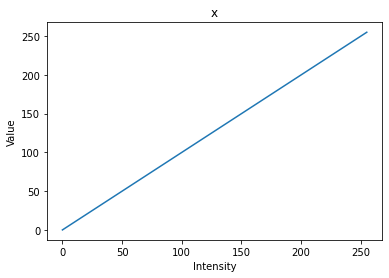

In [8]:
plt.figure()
plt.title("x")
plt.xlabel("Intensity")
plt.ylabel("Value")
plt.plot(x)

### Compute the histogram(x)

In [9]:
histogram_x, bin_edges_x = np.histogram(x, bins=256, range=(0, 256))
histogram_x

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

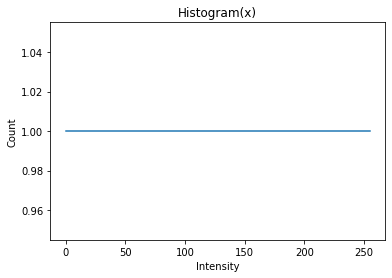

In [10]:
plt.figure()
plt.title("Histogram(x)")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges_x[0:-1], histogram_x)

### Encode(x)

In [11]:
k = np.searchsorted(boundaries, x, side="right") - 1
k

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

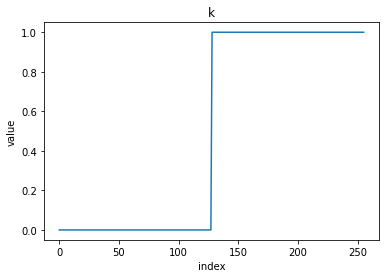

In [12]:
plt.figure()
plt.title("k")
plt.xlabel("index")
plt.ylabel("value")
plt.plot(k)

### Decode(k)

In [13]:
y = centroids[k]
y

array([ 63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,  63.5,
        63.5,  63.5,

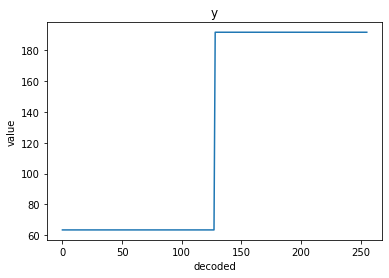

In [14]:
plt.figure()
plt.title("y")
plt.xlabel("decoded")
plt.ylabel("value")
plt.plot(y)

## Quantize an image

### Stuff for reading gray-scale images

In [15]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [16]:
%%bash
if [ -d "$HOME/repos/image_IO" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/image_IO ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/image_IO.git
fi

/home/vruiz/repos/image_IO ... 
Ya está actualizado.


In [17]:
%%bash
if [ -d "$HOME/repos/information_theory" ]; then
    cd $HOME/repos/image_IO
    echo "$HOME/repos/information_theory ... "
    git pull 
else
    cd $HOME/repos
    git clone https://github.com/vicente-gonzalez-ruiz/information_theory.git
fi

/home/vruiz/repos/information_theory ... 
Ya está actualizado.


In [18]:
!ln -sf ~/repos/image_IO/image_1.py .
!ln -sf ~/repos/image_IO/logging_config.py .

In [19]:
import image_1 as gray_image
import os

In [20]:
home = os.environ["HOME"]
fn = home + "/repos/MRVC/images/lena_bw/"
#fn = home + "/repos/MRVC/images/circle/"
#fn = home + "/repos/MRVC/images/Hommer_bw/"
!ls -l {fn}

total 148
-rw-r--r-- 1 vruiz vruiz 151199 feb 18  2022 000.png


### Read the image

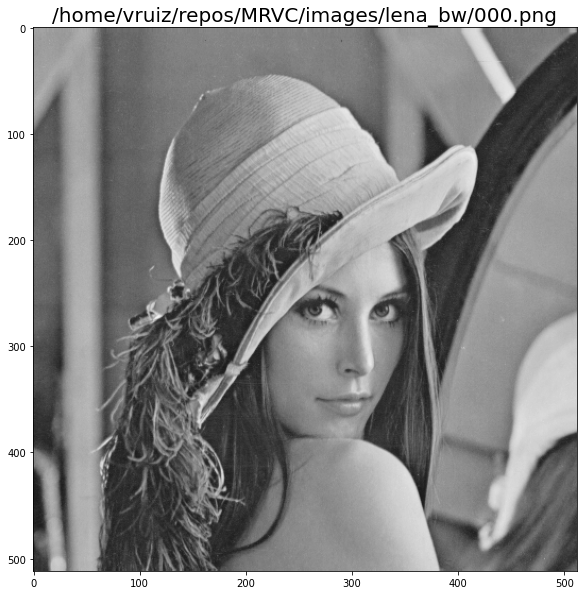

In [21]:
img = gray_image.read(fn, 0)
gray_image.show(img, fn + "000.png")

### Histogram of the image

In [22]:
histogram_img, bin_edges_img = np.histogram(img, bins=256, range=(0, 256))
#histogram[histogram==0] = 1
print("histogram", histogram_img)
print("\bin_edges", bin_edges_img)
print(len(histogram_img))

histogram [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    7   22
   28   63   93  135  177  224  306  420  508  607  778  922 1082 1279
 1429 1642 1756 1846 2038 2066 2007 2081 2053 2039 1969 1846 1741 1673
 1549 1478 1289 1249 1193 1026  959  948  910  868  786  801  771  776
  848  812  820  801  880  903  850  890  938  935  916  924  847  951
  935  965  994 1015 1072 1108 1124 1224 1194 1346 1413 1557 1628 1791
 1853 2105 1930 1899 1941 1840 1763 1737 1588 1498 1466 1336 1369 1389
 1363 1442 1381 1336 1409 1464 1544 1517 1626 1789 1790 1878 2061 2097
 2311 2300 2385 2483 2390 2262 2235 2116 1993 1858 1929 1889 2040 2128
 2270 2270 2341 2433 2466 2409 2214 2340 2285 2202 2314 2327 2374 2611
 2723 2690 2673 2493 2391 2286 2062 1846 1769 1628 1454 1403 1370 1247
 1201 1241 1139 1187 1350 1242 1225 1184 1190 1236 1108  950  919  820
  790  681  626  619  641  691  647  664  726  815  825  912  926 1

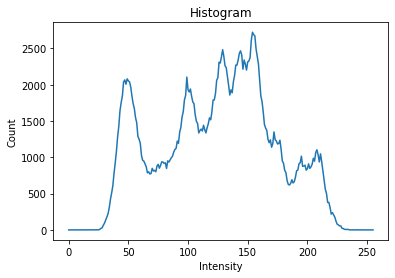

In [23]:
plt.figure()
plt.title("Histogram")
plt.xlabel("Intensity")
plt.ylabel("Count")
plt.plot(bin_edges_img[0:-1], histogram_img)

### Build the quantizer

In [24]:
P = histogram_img
M = 128
boundaries_img, centroids_img = compute_levels(P, M, max_iters=100)

initial_centroids [ 19.   39.5  42.   44.   46.   47.5  49.   50.5  52.   54.   56.   58.
  60.   62.5  65.5  68.5  71.5  74.5  77.5  80.5  83.5  86.5  89.   91.
  93.   95.   97.   99.  101.  103.  105.  107.  109.  111.  113.  115.
 117.  119.  121.  123.  124.5 125.5 126.5 127.5 128.5 129.5 130.5 131.5
 132.5 133.5 135.  137.  139.  140.5 141.5 142.5 143.5 144.5 145.5 146.5
 147.5 148.5 149.5 150.5 151.5 152.5 153.5 154.5 155.5 156.5 157.5 158.5
 159.5 160.5 162.  164.  166.  168.  170.  172.  174.  176.  178.  180.5
 183.5 187.  190.5 193.5 196.5 199.5 202.5 205.5 208.  210.5 213.5 217.5
 238. ] 97
b [  0.    29.25  40.75  43.    45.    46.75  48.25  49.75  51.25  53.
  55.    57.    59.    61.25  64.    67.    70.    73.    76.    79.
  82.    85.    87.75  90.    92.    94.    96.    98.   100.   102.
 104.   106.   108.   110.   112.   114.   116.   118.   120.   122.
 123.75 125.   126.   127.   128.   129.   130.   131.   132.   133.
 134.25 136.   138.   139.75 141.   142.   

In [25]:
print(boundaries_img, len(boundaries_img))

[  0.          32.83986366  38.29992509  42.09953754  44.25838729
  45.75170565  47.25170565  48.74830672  50.24830672  51.74193971
  53.48696022  55.48915661  57.73127092  60.22869653  62.7268882
  65.48214582  68.75419035  72.27710785  75.53616701  78.51444819
  81.51411754  84.26980039  86.76825486  89.27520135  91.52560799
  93.52708184  95.5240399   97.52783582  99.26591713 100.75273437
 102.49739161 104.48345422 106.48609794 108.75377383 111.26351389
 113.5029004  115.50064534 117.50258078 119.50972749 121.26193265
 122.5        123.5        124.5        125.5        126.5
 127.5        128.5        129.5        130.5        131.74316249
 133.24316249 135.0027308  137.0027308  138.5        139.5
 140.5        141.5        142.5        143.5        144.5
 145.5        146.5        147.5        148.5        149.5
 150.5        151.5        152.5        153.5        154.5
 155.5        156.5        157.5        158.73712052 160.23712052
 161.7396232  163.48516047 165.48378718 167.72

In [26]:
print(centroids_img, len(centroids_img))

[ 29.76217765  35.91754967  40.68230051  43.51677457  45.
  46.50341131  48.          49.49661345  51.          52.48387942
  54.49004101  56.48827222  58.97426963  61.48312343  63.97065297
  66.99363868  70.51474201  74.03947368  77.03286034  79.99603604
  83.03219905  85.50740174  88.02910798  90.52129472  92.52992126
  94.52424242  96.52383738  98.53183426 100.         101.50546875
 103.48931446 105.47759398 107.49460189 110.01294577 112.514082
 114.49171881 116.50957188 118.49558968 120.5238653  122.
 123.         124.         125.         126.         127.
 128.         129.         130.         131.         132.48632498
 134.         136.00546159 138.         139.         140.
 141.         142.         143.         144.         145.
 146.         147.         148.         149.         150.
 151.         152.         153.         154.         155.
 156.         157.         158.         159.47424103 161.
 162.47924639 164.49107455 166.47649981 168.9826864  171.53212456
 173.     

In [27]:
print(histogram_img)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    1    7   22
   28   63   93  135  177  224  306  420  508  607  778  922 1082 1279
 1429 1642 1756 1846 2038 2066 2007 2081 2053 2039 1969 1846 1741 1673
 1549 1478 1289 1249 1193 1026  959  948  910  868  786  801  771  776
  848  812  820  801  880  903  850  890  938  935  916  924  847  951
  935  965  994 1015 1072 1108 1124 1224 1194 1346 1413 1557 1628 1791
 1853 2105 1930 1899 1941 1840 1763 1737 1588 1498 1466 1336 1369 1389
 1363 1442 1381 1336 1409 1464 1544 1517 1626 1789 1790 1878 2061 2097
 2311 2300 2385 2483 2390 2262 2235 2116 1993 1858 1929 1889 2040 2128
 2270 2270 2341 2433 2466 2409 2214 2340 2285 2202 2314 2327 2374 2611
 2723 2690 2673 2493 2391 2286 2062 1846 1769 1628 1454 1403 1370 1247
 1201 1241 1139 1187 1350 1242 1225 1184 1190 1236 1108  950  919  820
  790  681  626  619  641  691  647  664  726  815  825  912  926 1016
  876 

### Encode

In [28]:
indexes_img = np.searchsorted(boundaries_img, img) - 1

In [29]:
print(indexes_img.shape)
print(np.min(indexes_img))
print(np.max(indexes_img))
print(np.unique(indexes_img))
print(len(np.unique(indexes_img)))

(512, 512)
0
96
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]
97


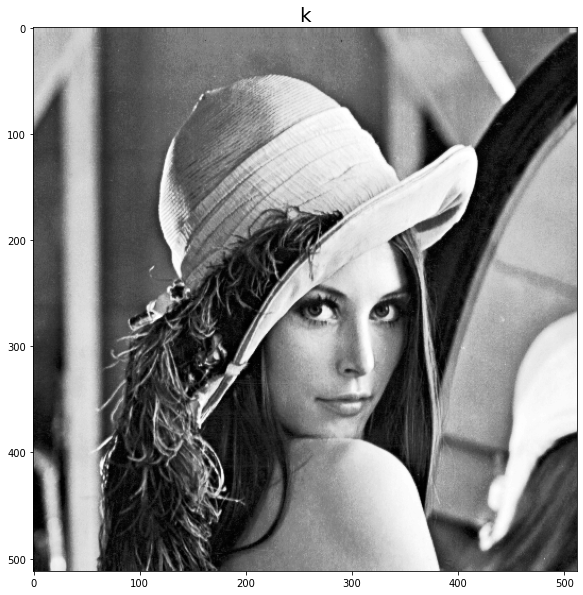

In [30]:
gray_image.show_normalized(indexes_img, "k")

### Decode

In [31]:
decoded_img = centroids_img[indexes_img]#.astype(np.uint8)

In [32]:
print(decoded_img.min(), decoded_img.max())

29.7621776504298 227.52994011976048


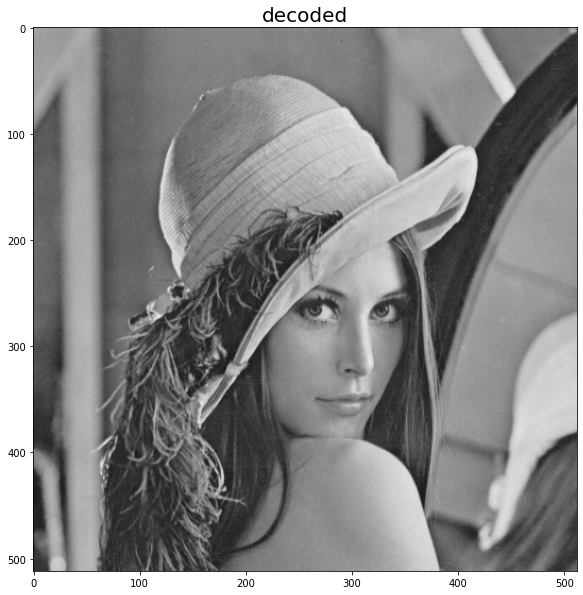

In [33]:
gray_image.show(decoded_img, "decoded")

## Quantization function

In [34]:
x = np.linspace(0, 255, 256) # Input samples
x

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [35]:
indexes_x = np.searchsorted(boundaries_img, x) - 1
indexes_x

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  4,  5,  5,  6,  7,  7,
        8,  9,  9, 10, 10, 11, 11, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15,
       15, 16, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 20,
       21, 21, 22, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 29,
       29, 30, 30, 31, 31, 32, 32, 33, 33, 33, 34, 34, 35, 35, 36, 36, 37,
       37, 38, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 49, 50, 50,
       51, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 73, 74, 75, 75, 76, 76, 77, 77, 78, 78,
       78, 79, 79, 80, 81, 81, 82, 82, 82, 83, 83, 84, 84, 84, 84, 85, 85,
       85, 86, 86, 86, 86, 87, 87, 88, 88, 88, 89, 89, 89, 90, 90, 90, 91,
       91, 91, 92, 92, 92, 93, 93, 93, 94, 94, 94, 94, 94, 95, 95, 95, 95,
       95, 95, 95, 96, 96

In [36]:
decoded_x = centroids_img[indexes_x]#.astype(np.uint8)
decoded_x

array([227.52994012,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  29.76217765,  29.76217765,  29.76217765,
        29.76217765,  35.91754967,  35.91754967,  35.91754967,
        35.91754967,  35.91754967,  35.91754967,  40.68230051,
        40.68230051,  40.68230051,  40.68230051,  43.51677457,
        43.51677457,  45.        ,  46.50341131,  46.50341131,
        48.        ,  49.49661345,  49.49661345,  51.        ,
        52.48387942,  52.48387942,  54.49004101,  54.49004101,
        56.48827222,  56.48827222,  58.97426963,  58.97426963,
        58.97426963,  61.48312343,  61.48312343,  63.97

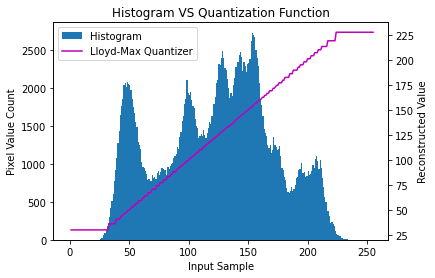

In [37]:
xlabel = "Input Sample"
ylabel = "Reconstructed Sample"
title = f"Lloyd-Max Quantizer ({fn}, $\M={M}$)"

ax1 = plt.subplot()
counts, bins = np.histogram(img, range(256))
l1 = ax1.bar(bins[:-1] - 0.5, counts, width=1, edgecolor='none')
ax2 = ax1.twinx()
l2, = ax2.plot(x[1:], decoded_x[1:], color='m')

plt.title("Histogram VS Quantization Function")
plt.legend([l1, l2], ["Histogram", "Lloyd-Max Quantizer"])
ax1.yaxis.set_label_text("Pixel Value Count")
ax2.yaxis.set_label_text("Reconstructed Value")
ax1.xaxis.set_label_text("Input Sample")
plt.show()

## Testing the library

In [38]:
import LloydMax_quantization as quantization

In [39]:
Q_step = 128
quantizer = quantization.LloydMax_Quantizer
Q = quantizer(Q_step=Q_step, counts=histogram_img)
print("decision_levels =", Q.get_decision_levels())
print("representation_levels =", Q.get_representation_levels())

decision_levels = [  0. 123. 255.]
representation_levels = [ 83.52786709 162.80215672]


In [40]:
#quantized_img, indexes = Q.encode_and_decode(img.flatten())
quantized_img, indexes = Q.encode_and_decode(img)

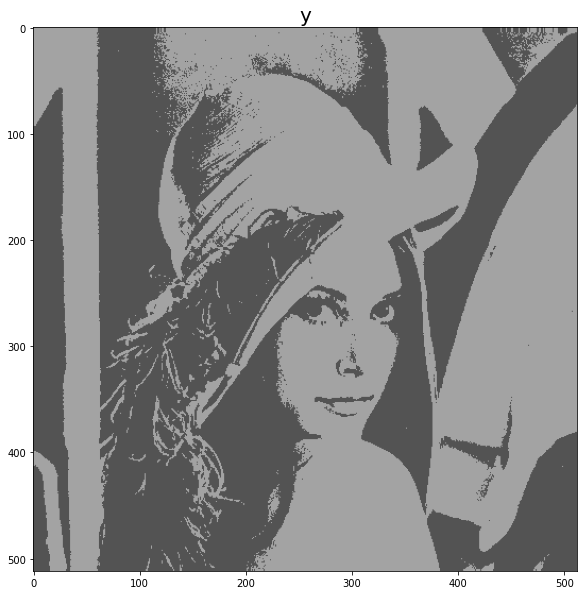

In [42]:
#gray_image.show_normalized(indexes.reshape(img.shape), fn + "000.png")
#gray_image.show(quantized_img, "y")
gray_image.show(quantized_img, "y")